In [13]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class FrameInterpolationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Directory containing folders of images.
            transform (callable, optional): Transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for folder_name in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder_name)
            if os.path.isdir(folder_path):
                frame1_path = os.path.join(folder_path, "frame1.jpg")
                frame2_path = os.path.join(folder_path, "frame2.jpg")
                frame3_path = os.path.join(folder_path, "frame3.jpg")
                if os.path.exists(frame1_path) and os.path.exists(frame2_path) and os.path.exists(frame3_path):
                    self.data.append((frame1_path, frame2_path, frame3_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame1_path, frame2_path, frame3_path = self.data[idx]
        frame1 = Image.open(frame1_path).convert("RGB")
        frame2 = Image.open(frame2_path).convert("RGB")
        frame3 = Image.open(frame3_path).convert("RGB")

        if self.transform:
            frame1 = self.transform(frame1)
            frame2 = self.transform(frame2)
            frame3 = self.transform(frame3)

        return frame1, frame2, frame3

# Example usage
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = FrameInterpolationDataset("1/datasets/train_10k", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [14]:
import torch
import torch.nn.functional as F

class NoiseScheduler:
    def __init__(self, num_steps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initializes the noise scheduler.
        
        Args:
            num_steps (int): Total number of diffusion steps.
            beta_start (float): Starting noise level.
            beta_end (float): Ending noise level.
        """
        self.num_steps = num_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        # Linear schedule for betas
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        
    def add_noise(self, image, t):
        """
        Add noise to an image at a given time step 't'.
        
        Args:
            image (Tensor): The original image.
            t (int): The current step of the diffusion process.
        
        Returns:
            Tensor: The noisy image.
        """
        beta_t = self.betas[t]
        noise = torch.randn_like(image)  # Gaussian noise
        noisy_image = image + torch.sqrt(beta_t) * noise
        return noisy_image

    def get_noise_schedule(self):
        return self.betas


In [15]:
from torch import nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [17]:
print(device)

cuda


In [19]:
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=6, out_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Initialize noise scheduler
scheduler = NoiseScheduler(num_steps=1000)

Epoch [1/50], Loss: 0.0054
Epoch [2/50], Loss: 0.0040
Epoch [3/50], Loss: 0.0036
Epoch [4/50], Loss: 0.0033
Epoch [5/50], Loss: 0.0033
Epoch [6/50], Loss: 0.0031
Epoch [7/50], Loss: 0.0030
Epoch [8/50], Loss: 0.0030
Epoch [9/50], Loss: 0.0029
Epoch [10/50], Loss: 0.0029
Epoch [11/50], Loss: 0.0029
Epoch [12/50], Loss: 0.0028
Epoch [13/50], Loss: 0.0028
Epoch [14/50], Loss: 0.0028
Epoch [15/50], Loss: 0.0028
Epoch [16/50], Loss: 0.0028
Epoch [17/50], Loss: 0.0027
Epoch [18/50], Loss: 0.0027
Epoch [19/50], Loss: 0.0027
Epoch [20/50], Loss: 0.0027
Epoch [21/50], Loss: 0.0027
Epoch [22/50], Loss: 0.0027
Epoch [23/50], Loss: 0.0027
Epoch [24/50], Loss: 0.0026
Epoch [25/50], Loss: 0.0026
Epoch [26/50], Loss: 0.0026
Epoch [27/50], Loss: 0.0026
Epoch [28/50], Loss: 0.0026
Epoch [29/50], Loss: 0.0026
Epoch [30/50], Loss: 0.0025
Epoch [31/50], Loss: 0.0025
Epoch [32/50], Loss: 0.0025
Epoch [33/50], Loss: 0.0025
Epoch [34/50], Loss: 0.0025
Epoch [35/50], Loss: 0.0024
Epoch [36/50], Loss: 0.0025
E

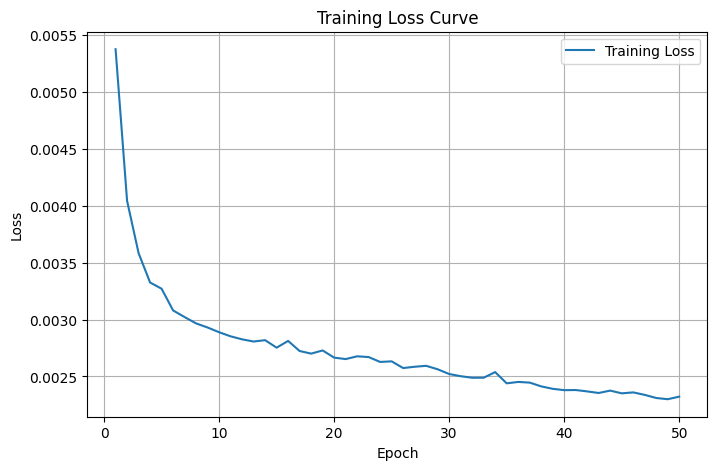

In [21]:

# Initialize lists to store metrics
train_losses = []
test_mse_scores = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    for frame1, frame2, frame3 in dataloader:
        frame1, frame2, frame3 = frame1.to(device), frame2.to(device), frame3.to(device)

        # Input: Concatenate frame1 and frame3 as context
        input_frames = torch.cat((frame1, frame3), dim=1)

        # Target: frame2 (middle frame)
        target_frame = frame2

        # Randomly pick a timestep for noise addition
        t = torch.randint(0, 1000, (1,)).item()  # Random timestep in the range of the scheduler
        noisy_frame = scheduler.add_noise(frame2, t)

        # Forward pass: Model tries to predict the clean frame2 (target_frame) from noisy_frame
        output_frame = model(torch.cat((frame1, frame3), dim=1))  # Concatenate frame1 and frame3 only


        # Compute loss
        loss = criterion(output_frame, target_frame)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

    # Average loss for the epoch
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


# Plot the training loss curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_dir, transform):
    test_dataset = FrameInterpolationDataset(test_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    mse_scores = []

    model.eval()
    with torch.no_grad():
        for frame1, frame2, frame3 in test_loader:
            frame1, frame2, frame3 = frame1.to(device), frame2.to(device), frame3.to(device)

            # Input: Concatenate frame1 and frame3 as context
            input_frames = torch.cat((frame1, frame3), dim=1)

            # Target: frame2 (middle frame)
            target_frame = frame2

            # Add noise to the test frame and predict the clean image
            t = torch.randint(0, 1000, (1,)).item()  # Random timestep
            noisy_frame = scheduler.add_noise(frame2, t)

            # Forward pass
            output_frame = model(torch.cat((frame1, frame3), dim=1))

            # Compute MSE for the batch
            mse = mean_squared_error(target_frame.cpu().numpy().flatten(), output_frame.cpu().numpy().flatten())
            mse_scores.append(mse)

    avg_mse = sum(mse_scores) / len(mse_scores)
    return avg_mse

# Evaluate the model on the test set
test_directory = "1/datasets/test_2k_original"
test_mse = evaluate_model(model, test_directory, transform=transform)
print(f"Test MSE Score: {test_mse:.4f}")

Test MSE Score: 0.0032


In [23]:
# saving teh model
torch.save(model.state_dict(), 'diffusion_model.pth')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


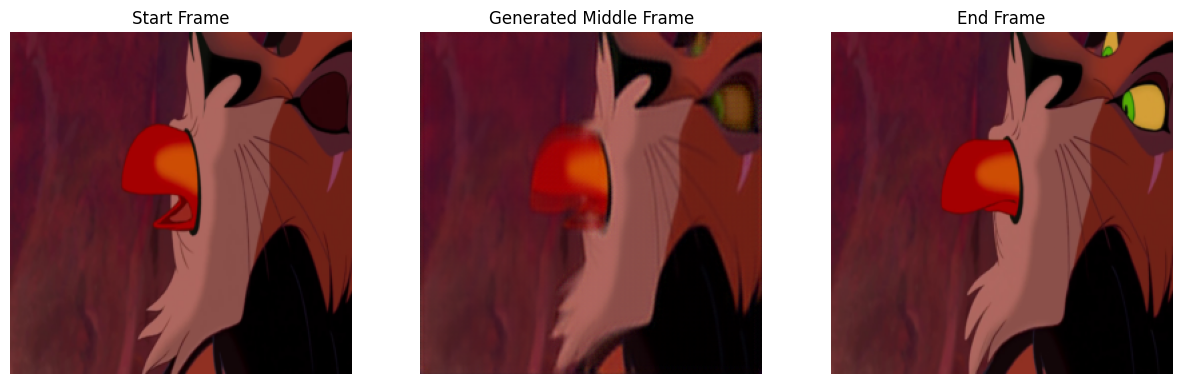

In [27]:
start_frame = "/teamspace/studios/this_studio/1/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame1.png"
end_frame = "/teamspace/studios/this_studio/1/datasets/test_2k_540p/Disney_v4_0_000249_s2/frame3.png"

start_frame = Image.open(start_frame).convert("RGB")
end_frame = Image.open(end_frame).convert("RGB")

start_frame = transform(start_frame).unsqueeze(0).to(device)
end_frame = transform(end_frame).unsqueeze(0).to(device)

# Generate the middle frame
model.eval()

with torch.no_grad():
    middle_frame = model(torch.cat((start_frame, end_frame), dim=1))

middle_frame = middle_frame.squeeze(0).cpu().numpy()
middle_frame = middle_frame.transpose(1, 2, 0)
middle_frame = (middle_frame * 255).astype(int)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(start_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0))
plt.title("Start Frame")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(middle_frame)
plt.title("Generated Middle Frame")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(end_frame.squeeze(0).cpu().numpy().transpose(1, 2, 0))
plt.title("End Frame")
plt.axis("off")

plt.show()